In [ ]:
pip install --upgrade torch torchvision

In [ ]:
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import shutil
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms

from sklearn.metrics import accuracy_score

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Datasets/mushrooms/mush.xlsx')[['image', 'label']]

In [ ]:
class_names = list(data['label'].unique())
os.mkdir('/content/images')
os.mkdir('/content/images/train_images')
os.mkdir('/content/images/valid_images')
for i in range(len(class_names)):
  os.mkdir(f'/content/images/train_images/{class_names[i]}')
  os.mkdir(f'/content/images/valid_images/{class_names[i]}')

In [ ]:
class_names

['Саркосцифа алая',
 'Лисичка настоящая',
 'Масленок обыкновенный',
 'Подберезовик',
 'Белый гриб',
 'Подосиновик',
 'Опёнок']

In [ ]:
valid_list = []
for i in range(len(data)):
  if i % 10 == 0:
    valid_list.append(i)

In [ ]:
train_data = data.drop(index=valid_list).reset_index(drop=True).copy()
valid_data = data.loc[valid_list].reset_index(drop=True).copy()

In [ ]:
!unzip /content/drive/MyDrive/Datasets/mushrooms/img.zip

In [ ]:
# for name in data['image']:                                    # Проверяем совпадения названия изображений и записей в таблице
#   if name.split('/')[-1] not in os.listdir('/content/img'):
#     print(name.split('/')[-1])

In [ ]:
for i, name in enumerate(train_data['image']):
  shutil.copy(f'/content/img/{name.split("/")[-1]}', f'/content/images/train_images/{train_data["label"][i]}/{name.split("/")[-1]}')
  os.remove(f'/content/img/{name.split("/")[-1]}')

for i, name in enumerate(valid_data['image']):
  shutil.copy(f'/content/img/{name.split("/")[-1]}', f'/content/images/valid_images/{valid_data["label"][i]}/{name.split("/")[-1]}')
  os.remove(f'/content/img/{name.split("/")[-1]}')
os.remove('/content/img')

In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((128,128)),    
    transforms.ToTensor(),
    ])

In [ ]:
data_dir = '/content/images'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=img_transforms)
                  for x in ['train_images', 'valid_images']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=2)
              for x in ['train_images', 'valid_images']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_images', 'valid_images']}
class_names = image_datasets['train_images'].classes

In [ ]:
convnext_base = models.convnext_base(pretrained=True) 

In [ ]:
for name, param in convnext_base.named_parameters():
  param.requires_grad = False

In [ ]:
convnext_base.classifier[2] = nn.Linear(1024,500)
convnext_base.classifier.append(nn.GELU())
convnext_base.classifier.append(nn.Dropout(0.3))
convnext_base.classifier.append(nn.Linear(500,len(class_names)))

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=500, bias=True)
  (3): GELU()
  (4): Dropout(p=0.3, inplace=False)
  (5): Linear(in_features=500, out_features=7, bias=True)
)

In [ ]:
optimizer = optim.Adam(convnext_base.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    best_metrics = 0
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        metrics = 0
        for i, batch in enumerate(val_loader):
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
              
            y_pred = torch.max(F.softmax(output, dim=1), dim=1)[1].numpy()
            metrics += accuracy_score(targets.numpy(), y_pred)
        valid_loss /= len(val_loader.dataset)
        metrics /= len(val_loader)

        if metrics > best_metrics:
          print('New best model with test accuracy:', metrics)
          torch.save(model, "/content/convnext_base_weight")
          best_metrics = metrics

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, metrics))

In [ ]:
train(convnext_base, optimizer, loss_fn, dataloaders['train_images'], dataloaders['valid_images'], epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

New best model with test accuracy: 0.4838709677419355


  2%|▏         | 1/50 [01:13<1:00:00, 73.48s/it]

Epoch: 0, Training Loss: 1.63, Validation Loss: 1.19, accuracy = 0.48
New best model with test accuracy: 0.6774193548387096


  4%|▍         | 2/50 [02:25<57:57, 72.45s/it]  

Epoch: 1, Training Loss: 1.06, Validation Loss: 0.82, accuracy = 0.68
New best model with test accuracy: 0.8709677419354839


  6%|▌         | 3/50 [03:36<56:20, 71.93s/it]

Epoch: 2, Training Loss: 0.77, Validation Loss: 0.64, accuracy = 0.87


  8%|▊         | 4/50 [04:46<54:41, 71.33s/it]

Epoch: 3, Training Loss: 0.60, Validation Loss: 0.53, accuracy = 0.87
New best model with test accuracy: 0.9354838709677419


 10%|█         | 5/50 [05:58<53:26, 71.26s/it]

Epoch: 4, Training Loss: 0.47, Validation Loss: 0.45, accuracy = 0.94


 12%|█▏        | 6/50 [07:07<51:44, 70.57s/it]

Epoch: 5, Training Loss: 0.45, Validation Loss: 0.45, accuracy = 0.87


 14%|█▍        | 7/50 [08:17<50:30, 70.48s/it]

Epoch: 6, Training Loss: 0.36, Validation Loss: 0.34, accuracy = 0.94


 16%|█▌        | 8/50 [09:27<49:17, 70.42s/it]

Epoch: 7, Training Loss: 0.29, Validation Loss: 0.38, accuracy = 0.87


 18%|█▊        | 9/50 [10:38<48:06, 70.40s/it]

Epoch: 8, Training Loss: 0.27, Validation Loss: 0.29, accuracy = 0.87
New best model with test accuracy: 0.967741935483871


 20%|██        | 10/50 [11:48<46:57, 70.43s/it]

Epoch: 9, Training Loss: 0.25, Validation Loss: 0.24, accuracy = 0.97
New best model with test accuracy: 1.0


 22%|██▏       | 11/50 [13:00<46:00, 70.77s/it]

Epoch: 10, Training Loss: 0.20, Validation Loss: 0.21, accuracy = 1.00


 24%|██▍       | 12/50 [14:10<44:44, 70.66s/it]

Epoch: 11, Training Loss: 0.19, Validation Loss: 0.21, accuracy = 0.94


 26%|██▌       | 13/50 [15:19<43:13, 70.10s/it]

Epoch: 12, Training Loss: 0.17, Validation Loss: 0.22, accuracy = 0.94


 28%|██▊       | 14/50 [16:26<41:33, 69.26s/it]

Epoch: 13, Training Loss: 0.17, Validation Loss: 0.20, accuracy = 0.94


 30%|███       | 15/50 [17:35<40:15, 69.01s/it]

Epoch: 14, Training Loss: 0.16, Validation Loss: 0.29, accuracy = 0.90


 32%|███▏      | 16/50 [18:45<39:17, 69.33s/it]

Epoch: 15, Training Loss: 0.21, Validation Loss: 0.20, accuracy = 0.94


 34%|███▍      | 17/50 [19:54<38:01, 69.14s/it]

Epoch: 16, Training Loss: 0.13, Validation Loss: 0.18, accuracy = 0.90


 36%|███▌      | 18/50 [21:01<36:40, 68.77s/it]

Epoch: 17, Training Loss: 0.12, Validation Loss: 0.16, accuracy = 0.94


 38%|███▊      | 19/50 [22:12<35:45, 69.20s/it]

Epoch: 18, Training Loss: 0.11, Validation Loss: 0.14, accuracy = 1.00


 40%|████      | 20/50 [23:20<34:32, 69.09s/it]

Epoch: 19, Training Loss: 0.09, Validation Loss: 0.14, accuracy = 0.94


 42%|████▏     | 21/50 [24:29<33:21, 69.03s/it]

Epoch: 20, Training Loss: 0.10, Validation Loss: 0.14, accuracy = 0.97


 44%|████▍     | 22/50 [25:37<32:05, 68.76s/it]

Epoch: 21, Training Loss: 0.09, Validation Loss: 0.16, accuracy = 0.94


 46%|████▌     | 23/50 [26:46<30:56, 68.75s/it]

Epoch: 22, Training Loss: 0.06, Validation Loss: 0.13, accuracy = 0.97


 48%|████▊     | 24/50 [27:54<29:36, 68.33s/it]

Epoch: 23, Training Loss: 0.07, Validation Loss: 0.13, accuracy = 0.94


 50%|█████     | 25/50 [29:02<28:25, 68.22s/it]

Epoch: 24, Training Loss: 0.06, Validation Loss: 0.13, accuracy = 0.94


 52%|█████▏    | 26/50 [30:10<27:15, 68.15s/it]

Epoch: 25, Training Loss: 0.05, Validation Loss: 0.13, accuracy = 0.97


 54%|█████▍    | 27/50 [31:19<26:15, 68.50s/it]

Epoch: 26, Training Loss: 0.06, Validation Loss: 0.12, accuracy = 0.97


 56%|█████▌    | 28/50 [32:28<25:12, 68.74s/it]

Epoch: 27, Training Loss: 0.05, Validation Loss: 0.11, accuracy = 0.97


 58%|█████▊    | 29/50 [33:38<24:10, 69.05s/it]

Epoch: 28, Training Loss: 0.06, Validation Loss: 0.11, accuracy = 0.94


 60%|██████    | 30/50 [34:48<23:05, 69.27s/it]

Epoch: 29, Training Loss: 0.05, Validation Loss: 0.09, accuracy = 1.00


 62%|██████▏   | 31/50 [35:58<21:59, 69.47s/it]

Epoch: 30, Training Loss: 0.06, Validation Loss: 0.12, accuracy = 0.94


 64%|██████▍   | 32/50 [37:08<20:55, 69.75s/it]

Epoch: 31, Training Loss: 0.04, Validation Loss: 0.11, accuracy = 0.97


 66%|██████▌   | 33/50 [38:17<19:41, 69.53s/it]

Epoch: 32, Training Loss: 0.06, Validation Loss: 0.11, accuracy = 0.94


 68%|██████▊   | 34/50 [39:25<18:25, 69.08s/it]

Epoch: 33, Training Loss: 0.05, Validation Loss: 0.11, accuracy = 0.97


 70%|███████   | 35/50 [40:34<17:14, 68.94s/it]

Epoch: 34, Training Loss: 0.06, Validation Loss: 0.09, accuracy = 1.00


 72%|███████▏  | 36/50 [41:42<16:00, 68.61s/it]

Epoch: 35, Training Loss: 0.03, Validation Loss: 0.08, accuracy = 1.00


 74%|███████▍  | 37/50 [42:50<14:52, 68.68s/it]

Epoch: 36, Training Loss: 0.04, Validation Loss: 0.10, accuracy = 0.97


 76%|███████▌  | 38/50 [44:00<13:46, 68.88s/it]

Epoch: 37, Training Loss: 0.04, Validation Loss: 0.11, accuracy = 0.97


 78%|███████▊  | 39/50 [45:07<12:32, 68.41s/it]

Epoch: 38, Training Loss: 0.06, Validation Loss: 0.10, accuracy = 0.94


 80%|████████  | 40/50 [46:14<11:21, 68.12s/it]

Epoch: 39, Training Loss: 0.04, Validation Loss: 0.08, accuracy = 0.97


 82%|████████▏ | 41/50 [47:21<10:09, 67.76s/it]

Epoch: 40, Training Loss: 0.03, Validation Loss: 0.08, accuracy = 0.97


 84%|████████▍ | 42/50 [48:28<08:59, 67.44s/it]

Epoch: 41, Training Loss: 0.04, Validation Loss: 0.08, accuracy = 0.97


 86%|████████▌ | 43/50 [49:36<07:52, 67.50s/it]

Epoch: 42, Training Loss: 0.03, Validation Loss: 0.07, accuracy = 1.00


 88%|████████▊ | 44/50 [50:43<06:44, 67.42s/it]

Epoch: 43, Training Loss: 0.03, Validation Loss: 0.09, accuracy = 0.97


 90%|█████████ | 45/50 [51:50<05:36, 67.23s/it]

Epoch: 44, Training Loss: 0.03, Validation Loss: 0.07, accuracy = 1.00


 92%|█████████▏| 46/50 [52:56<04:27, 66.99s/it]

Epoch: 45, Training Loss: 0.03, Validation Loss: 0.09, accuracy = 0.97


 94%|█████████▍| 47/50 [54:04<03:21, 67.14s/it]

Epoch: 46, Training Loss: 0.03, Validation Loss: 0.07, accuracy = 1.00


 96%|█████████▌| 48/50 [55:11<02:14, 67.09s/it]

Epoch: 47, Training Loss: 0.03, Validation Loss: 0.06, accuracy = 1.00


 98%|█████████▊| 49/50 [56:18<01:07, 67.10s/it]

Epoch: 48, Training Loss: 0.02, Validation Loss: 0.08, accuracy = 0.97


100%|██████████| 50/50 [57:29<00:00, 68.99s/it]

Epoch: 49, Training Loss: 0.02, Validation Loss: 0.08, accuracy = 1.00


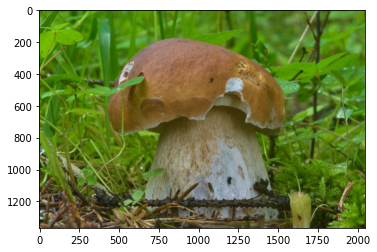

In [ ]:
img = Image.open("/content/images/valid_images/Белый гриб/1625305830_29-p-dobrii-grib-foto-31.jpg")
plt.imshow(img)
img = img_transforms(img)
img = torch.unsqueeze(img, 0)

In [ ]:
convnext_base.eval()
prediction = F.softmax(convnext_base(img), dim=1)
prediction = prediction.argmax()
print(class_names[prediction])

Белый гриб
